# COVID Respiratory Modeling
In this notebook we will implement the mathematical model for viral particle deposition in the respiratory tract.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve

## Parameters
Values for the Airflow, Virus and Generation Characteristics. **Described in SI units.** 

In [2]:
# Airflow characteristics
rho_f = 1.2e-3 # g cm^-3 #WRONG
mu = 1.81e-4 # g cm^-1 s^-1
Q0 = 30 # L min^-1
g = 980 # cm s^-2
lamda = 0.066e-4 # cm
K_b = 1.38e-16 # cm^2 g s^-2 K^-1
T = 298 # K

# SI units:
rho_f = 1.2 # kg m^-3
mu = mu*0.1 # kg m^-1 s^-1 
Q0 = Q0*1.667e-5 # m^3 s^-1
g = g*0.01 #m s^-1
lamda = lamda*0.01 #m
K_b = K_b*1e-7 # m^2 kg s^-2 K^-1
T = T # K

In [4]:
# Virus characteristics
C0 = 1e7 # Copies/mL
# A = 
d_p = 60 # nm
#d_p = 130 # nm
rho_p = 1.18 # g cm^-3
p = 8.2 # day^-1
c = 0.6 # day^-1
b = 3.9e-7 # (Copies/mL)^-1 day^-1
d = 4.71 # day^-1

# SI units: 

C0 = C0*1e6 # Copies/m^3
d_p = d_p*1e-9 # m
rho_p = rho_p*1000 # kg m^-3
p = p/86400 # s^-1
c = c/86400 # s^-1
b = b*1e-6/86400 # (Copies/m^3)^-1 s^-1
d = d/86400 # s^-1

In [344]:
# Generation characteristics
final_generation = 23

lengths = np.array([12, 4.76, 1.9, 1.76, 1.27, 1.07, 0.9, 0.76, 0.64, 0.54, 0.46, 0.39, 0.33, 0.27, 0.23, 0.2, 0.165, 0.14, 0.12, 0.099, 0.083, 0.07, 0.059, 0.05])
diameters = np.array([1.8, 1.22, 0.83, 0.56, 0.45, 0.35, 0.28, 0.23, 0.186, 0.154, 0.13, 0.109, 0.095, 0.082, 0.074, 0.061, 0.06, 0.054, 0.05, 0.047, 0.045, 0.043, 0.041, 0.04])

lengths_SI = [0.01*element for element in lengths] #in m
diameters_SI = [0.01*element for element in diameters] #in m

airway_depth = np.zeros(final_generation+2) #in cm
airway_depth[0]
for i in range(1,final_generation+2):
    airway_depth[i] = lengths[i-1] + airway_depth[i-1] 

## 1. Fluid Velocity and Airflow Rate

In [6]:
def velocity(Q,d):
    A = np.pi*(d/2)**2
    u = Q/A
    return u

In [7]:
def get_flow_rates(Q0):
    Q = {} #Dictionary for the flow rate
    Q[0] = Q0
    for i in range(1,final_generation+1):
        Q[i] = Q[i-1]/2
    return Q

def get_velocities(Q0):
    u = {} #Dictionary for the velocities
    u[0] = velocity(Q0,diameters_SI[0])
    Q = get_flow_rates(Q0)
    for i in range(1,final_generation+1):
        u[i] = velocity(Q[i],diameters_SI[i])
    return u

In [8]:
def simple_plot(data, color_code="Reds", title="", ylabel="", xlabel=""):

    sns.reset_orig()
    sns.set_palette(sns.color_palette())
    sns.set_color_codes()
    sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

    colors = sns.color_palette(color_code)
    colors.reverse()

    fig_flow, ax_flow = plt.subplots()
    ax_flow.set_title(title)
    ax_flow.set_ylabel(ylabel)
    ax_flow.set_xlabel(xlabel)
    ax_flow.xaxis.grid()
    ax_flow.yaxis.grid()

    final_colors = [colors[0]]
    final_lines = ['-']
    final_markers = ['s']
    final_labels = ["label"]
    for i in range(final_generation+1):
        ax_flow.plot(i, data[i], color=final_colors[0],
                     marker=final_markers[0], label=final_labels[0],
                     linestyle=final_lines[0])   
    

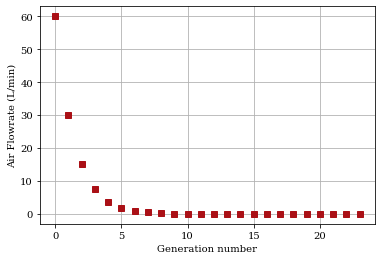

In [9]:
Q = get_flow_rates(Q0*2)

Q_paper = [60000*Q[i] for i in range(final_generation+1)]

simple_plot(Q_paper, ylabel="Air Flowrate (L/min)", xlabel="Generation number")

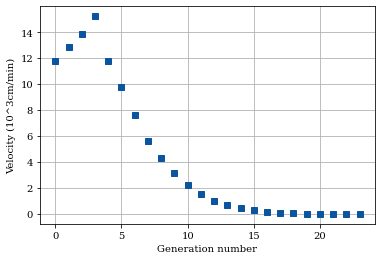

In [10]:
u = get_velocities(Q0)

u_paper = [6*u[i] for i in range(final_generation+1)]

simple_plot(u_paper,"Blues", ylabel="Velocity (10^3cm/min)", xlabel="Generation number")

## 2. Deposition
Impaction, Sedimentation and Diffusion

In [11]:
# Functions

def impaction(L,d,u,d_p):
    k_I = (1.3*rho_p*d_p**2*u)/(L*18*mu*d)
    return k_I


def sedimentation(L,d,Q,u,u_g,gen_number=None):
    
    def beta_sedimentation(L,d,u,u_g):
        B = (3*np.pi*L*u_g)/(16*u*d)
        return B
    
    B = beta_sedimentation(L,d,u,u_g)
    if B>1 :
        print('ERROR: in generation %d, beta = %f bigger than one' %(gen_number,B) )
        print('Where generation length = %f, diameter = %f, u = %f and u_g = %f' %(L,d,u,u_g))
        k_S = 0
    else:
         k_S = ((2*Q)/(np.pi*L)) * (2*B*np.sqrt(1-B**(2/3)) - B**(1/3)*np.sqrt(1-B**(2/3)) + np.arcsin(B**(1/3))) 

    return k_S


def diffusion(L,Q,d_p):
    
    def diffusivity(d_p):
        D = (K_b*T)/(3*np.pi*mu*d_p)
        return D
    
    def beta_diffusion(L,Q,d_p):
        D = diffusivity(d_p)
        B = np.pi*D*L/(4*Q)
        return B
    
    B = beta_diffusion(L,Q,d_p)
    k_d = (1 - 0.819*np.exp(-14.63*B) - 0.0976*np.exp(-89.22*B) - 0.0325*np.exp(-228*B) - 0.0509*np.exp(-125.9*B**(2/3)))
    return k_d


def get_u_g (d_p):
    C_c = 1 + (2*lamda/d_p)*(1.257+0.4*np.exp(-1.1*d_p/(2*lamda)))
    func = lambda u_g : u_g - (4*C_c*d_p**2*rho_p*(rho_p-rho_f)*g)/(3*mu*24*(1+0.15*(rho_f*u_g*d_p/mu)**(0.687)))
    
    u_g_initial_guess = 0.5
    u_g = fsolve(func, u_g_initial_guess)
    
    print("u_g = %f" % u_g)
    
    return u_g

In [12]:
def get_depositions(Q0,d_p):
    k_I = {}
    k_s = {}
    k_d = {}
    k = {}
    u = get_velocities(Q0)
    Q = get_flow_rates(Q0)
    u_g = get_u_g(d_p)
    for i in range(final_generation+1):
            k_I[i] = impaction(lengths_SI[i],diameters_SI[i],u[i],d_p)
            k_s[i] = sedimentation(lengths_SI[i],diameters_SI[i], Q[i], u[i], u_g, i)
            k_d[i] = diffusion(lengths_SI[i],Q[i], d_p)
            
    return {"k_I": k_I, "k_s": k_s, "k_d": k_d}

u_g = 0.000648
ERROR: in generation 23, beta = 1.005024 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.000648


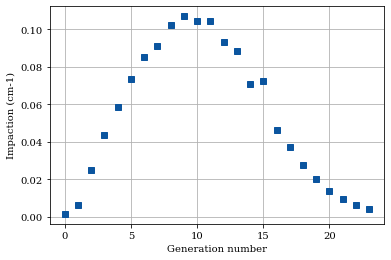

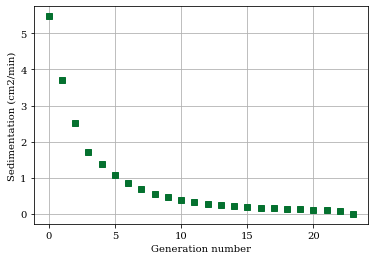

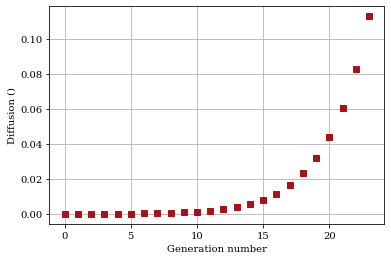

In [13]:
k_dict = get_depositions(Q0, d_p)

#Change k_I to cm^-1
k_I_newunits = [100*k_dict["k_I"][i] for i in range(final_generation+1)]
simple_plot(k_I_newunits, "Blues", ylabel="Impaction (cm-1)", xlabel="Generation number")

#Change k_s to cm^2/min
k_s_newunits = [600000*k_dict["k_s"][i] for i in range(final_generation+1)]
simple_plot(k_s_newunits, "Greens", ylabel="Sedimentation (cm2/min)", xlabel="Generation number")

simple_plot(k_dict["k_d"], ylabel="Diffusion ()", xlabel="Generation number")


## 3. Adjust deposition to paper values

In [14]:
def adjustment_to_paper_values(k_dict):
    # Change the depositions rates to match the paper values
    
    #IMPACTION: Original units: 1/m , Conversion factor: m/min, Result: 1/min
    k_I_conv_factor = 1000/0.07352 # m/min 
    k_dict["k_I"] = [k_I_conv_factor*k_dict["k_I"][i] for i in range(final_generation+1)]
    
    #SEDIMENTATION: Original units: m2/s , Conversion factor: m^-2 min/s, Result: 1/min
    k_s_conv_factor =  600000*10/2.529 # m^-2 min/s
    k_dict["k_s"] = [k_s_conv_factor*k_dict["k_s"][i] for i in range(final_generation+1)]

    #DIFFUSION: Original units: , Conversion factor: min^-1, Result: 1/min
    k_d_conv_factor = 1/100 # min^-1
    k_dict["k_d"] = [k_d_conv_factor*k_dict["k_d"][i] for i in range(final_generation+1)]
    
    k_dict["k"] = {}
    for i in range(final_generation+1):
        k_dict["k"][i] = k_dict["k_I"][i] + k_dict["k_s"][i] + k_dict["k_d"][i]
    
    return k_dict
    

In [15]:
def deposition_plot(k_dict, ylabel="Deposition (min-1)", xlabel="Generation number"):
    sns.reset_orig()
    sns.set_palette(sns.color_palette())
    sns.set_color_codes()
    sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

    blues = sns.color_palette("Blues")
    blues.reverse()
    reds = sns.color_palette("Reds")
    reds.reverse()
    greens = sns.color_palette("Greens")
    greens.reverse()

    set2 = sns.color_palette()
    set2.reverse()


    fig_flow, ax_flow = plt.subplots()
    ax_flow.set_title(" ")
    ax_flow.set_ylabel(ylabel)
    ax_flow.set_xlabel(xlabel)
    ax_flow.yaxis.grid()
    ax_flow.xaxis.grid()

    final_colors = set2
    final_lines = ['-']
    final_markers = ['s']
    final_labels = ["total", "impaction", "sedimentation", "10^4 diffusion"]
    
    # In the paper they plot k_d * 10^4
    k_d_e4 = [10000*k_dict["k_d"][i] for i in range(final_generation+1)]
    
    for i in range(final_generation+1):
        if i == 0:
            labels = final_labels
        else:
            labels = ["_nolegend_", "_nolegend_", "_nolegend_", "_nolegend_"]
        ax_flow.plot(i, k_dict["k"][i], color=final_colors[0],
                     marker=final_markers[0], label=labels[0],
                     linestyle=final_lines[0])
        ax_flow.plot(i, k_dict["k_I"][i], color=final_colors[1],
                     marker=final_markers[0], label=labels[1],
                     linestyle=final_lines[0])  
        ax_flow.plot(i, k_dict["k_s"][i], color=final_colors[2],
                     marker=final_markers[0], label=labels[2],
                     linestyle=final_lines[0])  
        ax_flow.plot(i, k_d_e4[i], color=final_colors[3],
                     marker=final_markers[0], label=labels[3],
                     linestyle=final_lines[0])
    ax_flow.legend()


u_g = 0.000648
ERROR: in generation 23, beta = 1.005024 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.000648


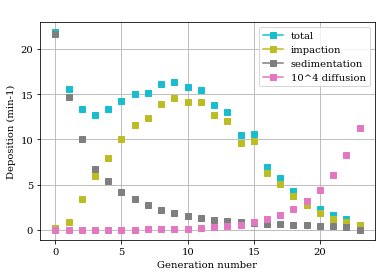

In [16]:
deposition_plot(adjustment_to_paper_values(get_depositions(Q0, d_p)))

In [17]:
def four_plot(data, titles=["","","",""], color_code="Reds", xlabel="Airway Generation Number", ylabel="", ylim=None):
    
    sns.reset_orig()
    sns.set_palette(sns.color_palette())
    sns.set_color_codes()
    sns.set_style({'font.family':'serif', 'font.serif':'Helvetica'})

    colors = sns.color_palette(color_code)
    colors.reverse()

    fig, ax = plt.subplots(1,4,figsize=(18,4))
    
    for i in range(4):
        ax[i].set_title(titles[i])
        ax[i].set_ylabel(ylabel)
        ax[i].set_xlabel(xlabel)
        ax[i].xaxis.grid()
        ax[i].yaxis.grid()
        
        if ylim is not None:
            ax[i].set_ylim(ylim)

        final_colors = [colors[0]]
        final_lines = ['-']
        final_markers = ['s']
        final_labels = ["label"]
        for j in range(final_generation+1):
            ax[i].plot(j, data[i][j], color=final_colors[0],
                         marker=final_markers[0], label=final_labels[0],
                         linestyle=final_lines[0]) 
    
    

u_g = 0.000777
ERROR: in generation 23, beta = 1.206338 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.000777
u_g = 0.001058
ERROR: in generation 23, beta = 1.641435 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.001058
u_g = 0.001367
ERROR: in generation 22, beta = 1.283084 bigger than one
Where generation length = 0.000590, diameter = 0.000410, u = 0.000903 and u_g = 0.001367
ERROR: in generation 23, beta = 2.121677 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.001367
u_g = 0.001707
ERROR: in generation 22, beta = 1.601899 bigger than one
Where generation length = 0.000590, diameter = 0.000410, u = 0.000903 and u_g = 0.001707
ERROR: in generation 23, beta = 2.648862 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.001707


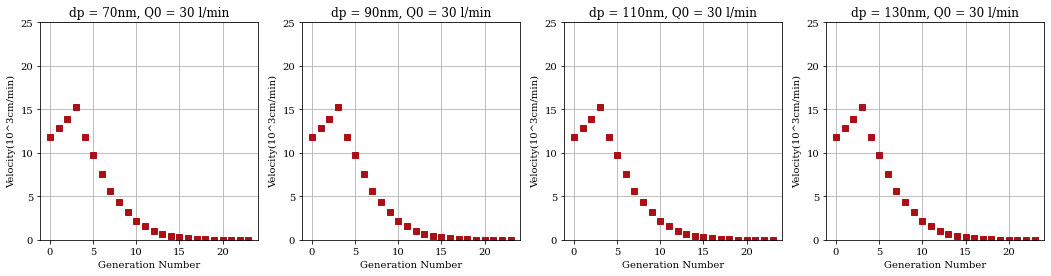

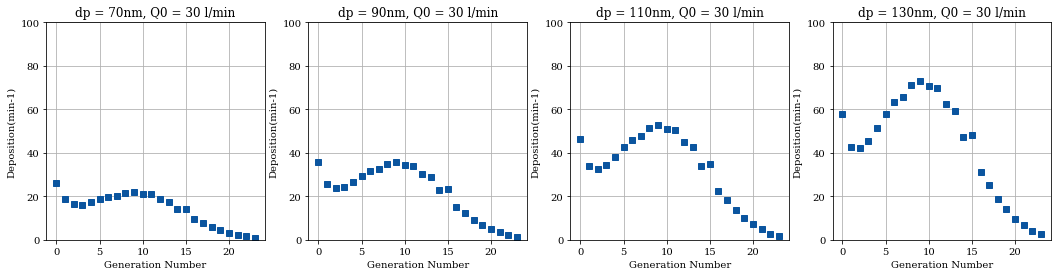

In [20]:
list_Q0_paper = [15, 30, 45, 60] #l/min
list_dp_paper = [70, 90, 110, 130] #nm

list_Q0 = np.zeros(len(list_Q0_paper))
list_dp = np.zeros(len(list_dp_paper))
list_Q0 = [list_Q0_paper[i]*1.667e-5 for i in range(len(list_Q0))] #m3/s 
list_dp = [list_dp_paper[i]*1e-9 for i in range(len(list_dp))] #m


u = {}
u_paper = {}
k = {}
title = {}
for i in range(4):
    Q0_index = 1
    d_p_index = i
    u[i] = get_velocities(list_Q0[Q0_index])
    u_paper[i] = [6*u[i][k] for k in range(final_generation+1)]
    k[i] = adjustment_to_paper_values(get_depositions(list_Q0[Q0_index], list_dp[d_p_index]))['k']
    title[i] = f"dp = {(list_dp_paper[d_p_index]):.0f}nm, Q0 = {list_Q0_paper[Q0_index]:.0f} l/min"
    
four_plot(u_paper, titles=title, xlabel="Generation Number", ylabel="Velocity(10^3cm/min)", ylim=(0,25))
four_plot(k, titles=title, color_code='Blues', xlabel="Generation Number", 
          ylabel="Deposition(min-1)", ylim=(0,100))





u_g = 0.001058
ERROR: in generation 21, beta = 1.235180 bigger than one
Where generation length = 0.000700, diameter = 0.000430, u = 0.000821 and u_g = 0.001058
ERROR: in generation 22, beta = 1.985316 bigger than one
Where generation length = 0.000590, diameter = 0.000410, u = 0.000452 and u_g = 0.001058
ERROR: in generation 23, beta = 3.282871 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000237 and u_g = 0.001058
u_g = 0.001058
ERROR: in generation 23, beta = 1.641435 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.001058
u_g = 0.001058
ERROR: in generation 23, beta = 1.094290 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000712 and u_g = 0.001058
u_g = 0.001058


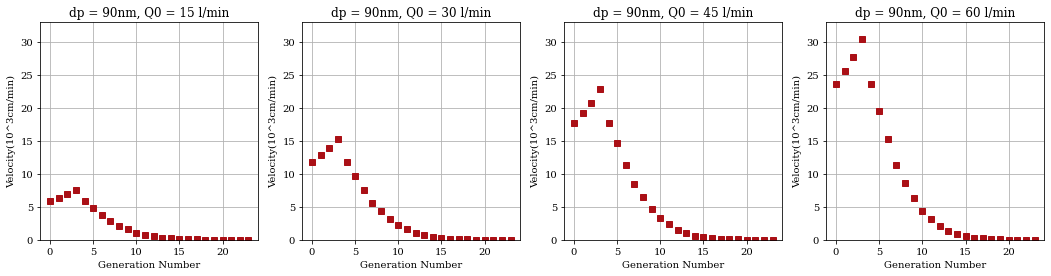

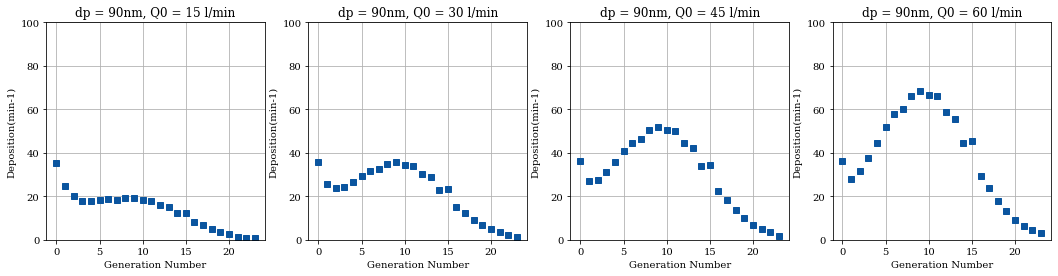

In [21]:
u = {}
u_paper = {}
k = {}
title = {}
for i in range(4):
    Q0_index = i
    d_p_index = 1
    u[i] = get_velocities(list_Q0[Q0_index])
    u_paper[i] = [6*u[i][k] for k in range(final_generation+1)]
    k[i] = adjustment_to_paper_values(get_depositions(list_Q0[Q0_index], list_dp[d_p_index]))['k']
    title[i] = f"dp = {(list_dp_paper[d_p_index]):.0f}nm, Q0 = {list_Q0_paper[Q0_index]:.0f} l/min"
    
four_plot(u_paper, titles=title, xlabel="Generation Number", ylabel="Velocity(10^3cm/min)", ylim=(0,33))
four_plot(k, titles=title, color_code='Blues', xlabel="Generation Number", 
          ylabel="Deposition(min-1)", ylim=(0,100))

## 4. Obtain the concentration profile

In [317]:
def get_concentrations(Q0,C0,d_p):
    
    def diffusivity(d_p):
        D = (K_b*T)/(3*np.pi*mu*d_p)
        return D
    
    def concentration(C_previous, L, u, D, k, p):
    #C = ((u[i]*C_previous)/(u[i]+np.sqrt(u[i]**2+4*D*(k-p)))) * np.exp( (u[i]-np.sqrt(u[i]**2+4*D(k-p))*x)/(2*D) )
    
    
        D = diffusivity(d_p)
        const1 = (u) / (u+np.sqrt(u**2+4*D*(k-p)))
        const2 = (u-np.sqrt(u**2+4*D*(k-p))) / (2*D)
        
        C = const1*C_previous*np.exp(const2*L)
        return C
    
    k = adjustment_to_paper_values(get_depositions(Q0, d_p))["k"]
    #Convert to SI units
    k = [(1/60)*k[i] for i in range(final_generation+1)]
    
    #simple_plot(k)
    
    u = get_velocities(Q0)
    C = np.zeros(final_generation+2)
    C[0] = C0
    D = diffusivity(d_p)
    
    for i in range(1,final_generation+2):        
        C[i] = concentration(C[i-1], lengths_SI[i-1], u[i-1], D, k[i-1], p)

    return C

In [23]:
'''
from scipy.integrate import quad

def integrand(x, const1, const2):
    return const1*np.exp(const2*x)
  
def concentration(C_previous, L, u, d_p, k, p):
    #C = ((u[i]*C_previous)/(u[i]+np.sqrt(u[i]**2+4*D*(k-p)))) * np.exp( (u[i]-np.sqrt(u[i]**2+4*D(k-p))*x)/(2*D) )
    
    def diffusivity(d_p):
        D = (K_b*T)/(3*np.pi*mu*d_p)
        return D
    
    D = diffusivity(d_p)
    const1 = (u*C_previous) / (u+np.sqrt(u**2+4*D*(k-p)))
    const2 = (u-np.sqrt(u**2+4*D*(k-p))) / (2*D)
    I = quad(integrand, 0, L, args=(const1,const2))
    C = I[0]/L
    return C

def get_concentrations(Q0,C0,d_p):
    
    k = adjustment_to_paper_values(get_depositions(Q0, d_p))["k"]
    #Convert to SI units
    k = [(1/60)*k[i] for i in range(final_generation+1)]
    
    #simple_plot(k)
    
    u = get_velocities(Q0)
    C = {}
    #C[0] = C0
    for i in range(final_generation+1):
        if i == 0:
            C[i] = concentration(C0, lengths_SI[i], u[i], d_p, k[i], p)
        else:
            C[i] = concentration(C[i-1], lengths_SI[i], u[i], d_p, k[i], p)

    return C

'''

u_g = 0.000648
ERROR: in generation 23, beta = 1.005024 bigger than one
Where generation length = 0.000500, diameter = 0.000400, u = 0.000474 and u_g = 0.000648


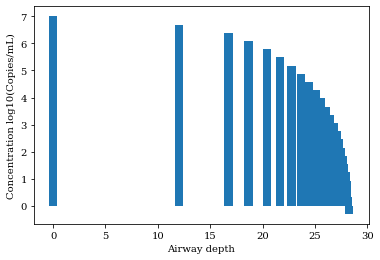

In [354]:
C0_star = 1e7*1e6
C = get_concentrations(Q0, C0_star, d_p)
#print(C)

C_in_ml = [1e-6*C[i] for i in range(final_generation+2)]
C_log_in_ml = [np.log10(C_in_ml[i]) for i in range(final_generation+2)]
bar_plot(C_log_in_ml, airway_depth, log=False, xlabel="Airway depth", ylabel="Concentration log10(Copies/mL)")

In [355]:
def bar_plot(ydata, xdata=range(final_generation+1), title="", ylabel="", xlabel="",log=True):
    
    plt.bar(xdata,ydata)
    plt.title(title)
    if log:
        plt.yscale('log')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

def two_bar_plot(data1, data2, xdata=range(final_generation+2), title="", ylabel="", xlabel="",log=True):
    
    plt.bar(xdata,data2)
    plt.bar(xdata,data1)
    plt.title(title)
    if log:
        plt.yscale('log')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    #plt.bar(xdata,data2)

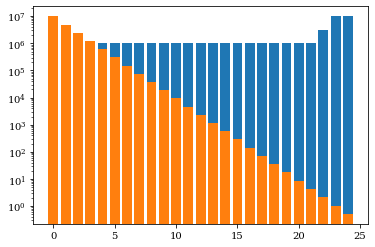

In [376]:
# ACE2 concentrations in Copies/mL
A = [9.419354838709676, 8, 7.225806451612902, 7.041474654377879, 6.9308755760368665, 6.783410138248847, 6.746543778801843, 6.709677419354839, 6.6728110599078345, 6.433179723502303, 6.211981566820276, 6.193548387096774, 5.050691244239632, 5.216589861751152, 5.400921658986175, 5.585253456221198, 5.788018433179723, 5.8433179723502295, 5.8433179723502295, 5.880184331797234, 5.935483870967742, 5.953917050691244, 6.24884792626728, 6.857142857142856, 7.059907834101382]
A = np.round(A,1)
A = [10**6 for i in range(len(A))]
#'''
A[0] = 10**7
A[1] = 10**(6.5)
A[22] = 10**(6.5)
A[23] = 10**7
A[24] = 10**7
#'''
#A = [10**A[i] for i in range(len(A))]

#I found that there are 25 elements in A (the plot they have on the paper for ACE2)

#print(len(C_in_ml), len(A), len(lengths_SI))
two_bar_plot(C_in_ml,A)

## 5. Viral dynamics

In [377]:
from scipy.integrate import odeint

In [378]:

b_days_ml = b*86400*10**6 # (Copies/mL)^-1 day^-1
b_days_m3 = b*86400 # (Copies/m^3)^-1 day^-1
p_days = p*86400 # day^-1
c_days = c*86400
d_days = d*86400


In [379]:
def dynamics(x,t): 
    dx = [0,0,0]
    dx[0] = -b_days_ml*x[0]*x[2]
    dx[1] = b_days_ml*x[0]*x[2] - d_days*x[1]
    dx[2] = p_days*x[1] -c_days*x[2]
    return dx

<ipython-input-380-c7c107b26e91>:6: RuntimeWarning: divide by zero encountered in log10
  N_log = np.log10(N)


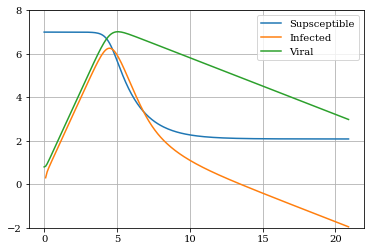

In [380]:
# Check dynamics are the same

x = [10**(7),0,10**(0.8)]
t = np.arange( 0., 21, 0.1)
N = odeint(dynamics, x, t)
N_log = np.log10(N)

plt.plot(t, N_log)
plt.legend(['Supsceptible','Infected','Viral'])
plt.grid()
plt.ylim(-2,8)
plt.show()

In [381]:
def model_dynamics(viral_initial, susceptible_initial, time):
    '''
    Creates a dictionary of dictionaries
    dncs: dictionary
        contains 3 subdictionaries: 'susceptible', 'infected', 'viral'
        contains the time vector: 'time'
    dncs['viral']: dictionary
        contains subsubdictionaries: '0', '1' ... '23' for each generation
    dncs['viral'][3]: dictionary
        list of the values of the virus concentration along time for generation 3
    '''
    
    dncs = {'susceptible': {}, 'infected': {}, 'viral': {}, 'time': time}
    #t = np.arange( 0., 60, 1)

    for i in range(final_generation+2):
        x = [susceptible_initial[i],0,viral_initial[i]]
        N = odeint(dynamics, x, t)
        #N = np.round(N)

        dncs['susceptible'][i] = (N[:,0])
        dncs['infected'][i] = (N[:,1])
        dncs['viral'][i] = (N[:,2])
        
    return dncs
        

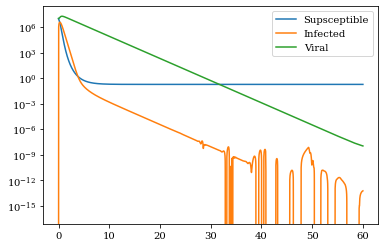

In [382]:

t = np.arange( 0., 60, 0.01)
dynamics_dict = model_dynamics(C_in_ml, A, t)

j = 0
to_plot = np.transpose([dynamics_dict['susceptible'][j],dynamics_dict['infected'][j],dynamics_dict['viral'][j]])
plt.plot(t, to_plot)
plt.legend(['Supsceptible','Infected','Viral'])
plt.yscale("log")
plt.show()

In [383]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
from matplotlib import cm
import random

def plot_viral(dncs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    t = np.array(dncs["time"])
    color = cm.viridis(np.linspace(0.2,0.9,final_generation+2))
    color = color[::1]
    
    for i in range(final_generation+2):
        V = np.array(dynamics_dict['viral'][i]) 
        ax.plot(t, V, c=color[i])
    
    plt.yscale('log')



def plot_3D(dncs): 

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    X = np.array(dncs["time"]) #days
    Y = airway_depth
    #Y = range(final_generation+1)
    Z = np.zeros((len(Y), len(X)))

    for i in range(final_generation+2):
        V = np.array(dynamics_dict['viral'][i]) 
        #V: Vector containing the viral conc. over time for generation i
        for j in range(0,len(t)):
            #Z[i,j] = np.log10(V[j])
            
            if V[j] < 10**(-10):
                Z[i,j] = -12
            else:
                Z[i,j] = np.log10(V[j])

    X, Y = np.meshgrid(X, Y)

    ax.plot_surface(X, Y, Z, cmap=cm.jet)



    ax.set_xlabel('Days')
    ax.set_ylabel('Airway Depth (cm)')
    ax.set_zlabel('Virus C (log10(Copies/mL))')
    ax.set_ylim(30,0)
    ax.set_zlim(-10, 10)
    
    plt.show()


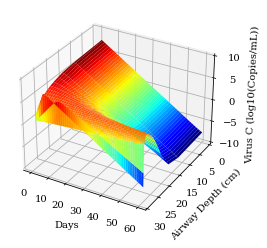

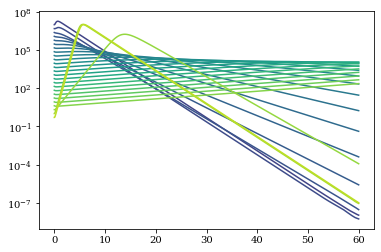

In [384]:
plot_3D(dynamics_dict)
plot_viral(dynamics_dict)